# 전처리 이용하지 않는, perplexity 최적화 토픽 수 찾기
# 리턴값 = [[토픽1의 토큰들], [토픽2의 토큰들], ... ]
# 작동 확인 시 순서대로 실행!

In [14]:
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from kiwipiepy import Kiwi
import matplotlib.pyplot as plt

In [24]:
def sklda(plaintext, n_top_words=5, n_iter=30):
    """
    ------------------------------------------------------------------------------
    
    텍스트를 받아 lda로 토픽을 나눕니다.
    토픽 수 별로 perplexity를 계산 한 후, perplexity값이 가장 낮은 토픽 수로 분석한 결과를 리스트로 리턴합니다.
    
    ------------------------------------------------------------------------------
    
    파라미터 설명
    
    plaintext : txt, 인스타그램 포스트들이 수집된 원문 텍스트. 'HOTKEY123!@#'로 포스트들을 구분한다.
    n_top_words : int, 각 토픽 별로 상위 몇 개의 단어를 리턴할 지
    n_iter : int, lda 분석 반복 수
    
    ------------------------------------------------------------------------------
    """
    def plot_top_words(model, feature_names, n_top_words, title):
        fig, axes = plt.subplots(1, len(topic_list), figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            print('Topic {}: {}'.format(topic_idx, ' '.join(top_features)))
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=3, bottom=0.5, wspace=0.1, hspace=1)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.show()
    
# 형태소분석기 키위 인스턴스 생성
    kiwi = Kiwi()
    kiwi.prepare()
      
# 인스타그램의 각 post들로 구성된 list 생성
    doc = plaintext.replace('#','').split('HOTKEY123!@')
# 전처리함수에서 원문반환이 될 경우 아래로 변경(구분자, 파라미터 등은 함수에 맞춰 변경필요)
# doc = preprocess(plaintext, sep='HOTKEY123!@#', 원문반환)

    print("\nExtracting kiwi features for LDA...")
    t0 = time()
    t1 = time()

# sklearn CountVectorizer의 tokenizer 변수에 넣을 함수 정의
    def tokenize_ko(doc):
        tokens = kiwi.tokenize(doc)
#         tagset = {'VA-I',  'MAG', 'XR', 'NNP', 'NNG'} <- 추가로 사용해 볼 만 한 태그들
        tagset = {'NNP', 'NNG'}
        results = []
        for token in tokens:
            if token.tag in tagset:
                results.append(token.form)
        return results

# sklearn CountVectorizer를 통한 전처리
    kiwi_vectorizer = CountVectorizer(min_df=2, max_features=1000, tokenizer=tokenize_ko)
    kiwivoca = kiwi_vectorizer.fit_transform(doc)
    print("done in %0.3fs." % (time() - t0))

# sklearn lda 분석을 통해 2~5개의 토픽 수 중 perplexity가 가장 낮은 값 찾기
    print("\nFinding the optimal number of topics...")
    t0 = time()
    perplexity = []
    for i in range(2,6):
        lda = LatentDirichletAllocation(
            n_components=i,
            max_iter=n_iter,
            learning_method="online",
            learning_offset=50.0,
            random_state=0,
        )
        lda.fit(kiwivoca)
        perplexity.append(lda.perplexity(kiwivoca))
        
# 가장 낮은 perplexity 값을 가지는 최적의 토픽 수로 저장
    n_topics=perplexity.index(min(perplexity))+2
    print("done in %0.3fs." % (time() - t0), f"the optimal number of topics is {n_topics}")

# 최적의 토픽 수로 lda분석
    print("\nFitting LDA models with KIWI features, number of topics=%d, max_iter=%d" % (n_topics, n_iter))
    t0 = time()
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=n_iter,
        learning_method="online",
        learning_offset=50.0,
        random_state=0,
    )
    lda.fit(kiwivoca)

# 토픽 넘버 : 해당 토픽의 토큰들 의 형태로 출력, 같은 토픽의 토큰들로 구성된 리스트 생성
    kiwi_feature_names = kiwi_vectorizer.get_feature_names_out()
    topic_list = []
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [kiwi_feature_names[i] for i in top_features_ind]
        topic_list.append(top_features)
        print('Topic {}: {}'.format(topic_idx+1, ' '.join(top_features))) 
        
    print("done in %0.3fs." % (time() - t0))
    
    kiwi_feature_names = kiwi_vectorizer.get_feature_names_out()
    plot_top_words(lda, kiwi_feature_names, n_top_words, "Topics in LDA model")

    print("in total, %0.3fs." % (time() - t1))
    return topic_list

In [25]:
with open('월드컵_1203.txt','r',encoding='utf-8') as file:
    plaintext = file.read()

<Figure size 640x480 with 0 Axes>


Extracting kiwi features for LDA...
done in 1.143s.

Finding the optimal number of topics...
done in 4.571s. the optimal number of topics is 2

Fitting LDA models with KIWI features, number of topics=2, max_iter=30
Topic 1: 월드컵 대한민국 강 진출 축구
Topic 2: 스타 그램 월드컵 유머 대한민국
done in 0.962s.
Topic 0: 월드컵 대한민국 강 진출 축구
Topic 1: 스타 그램 월드컵 유머 대한민국
in total, 6.699s.


[['월드컵', '대한민국', '강', '진출', '축구'], ['스타', '그램', '월드컵', '유머', '대한민국']]

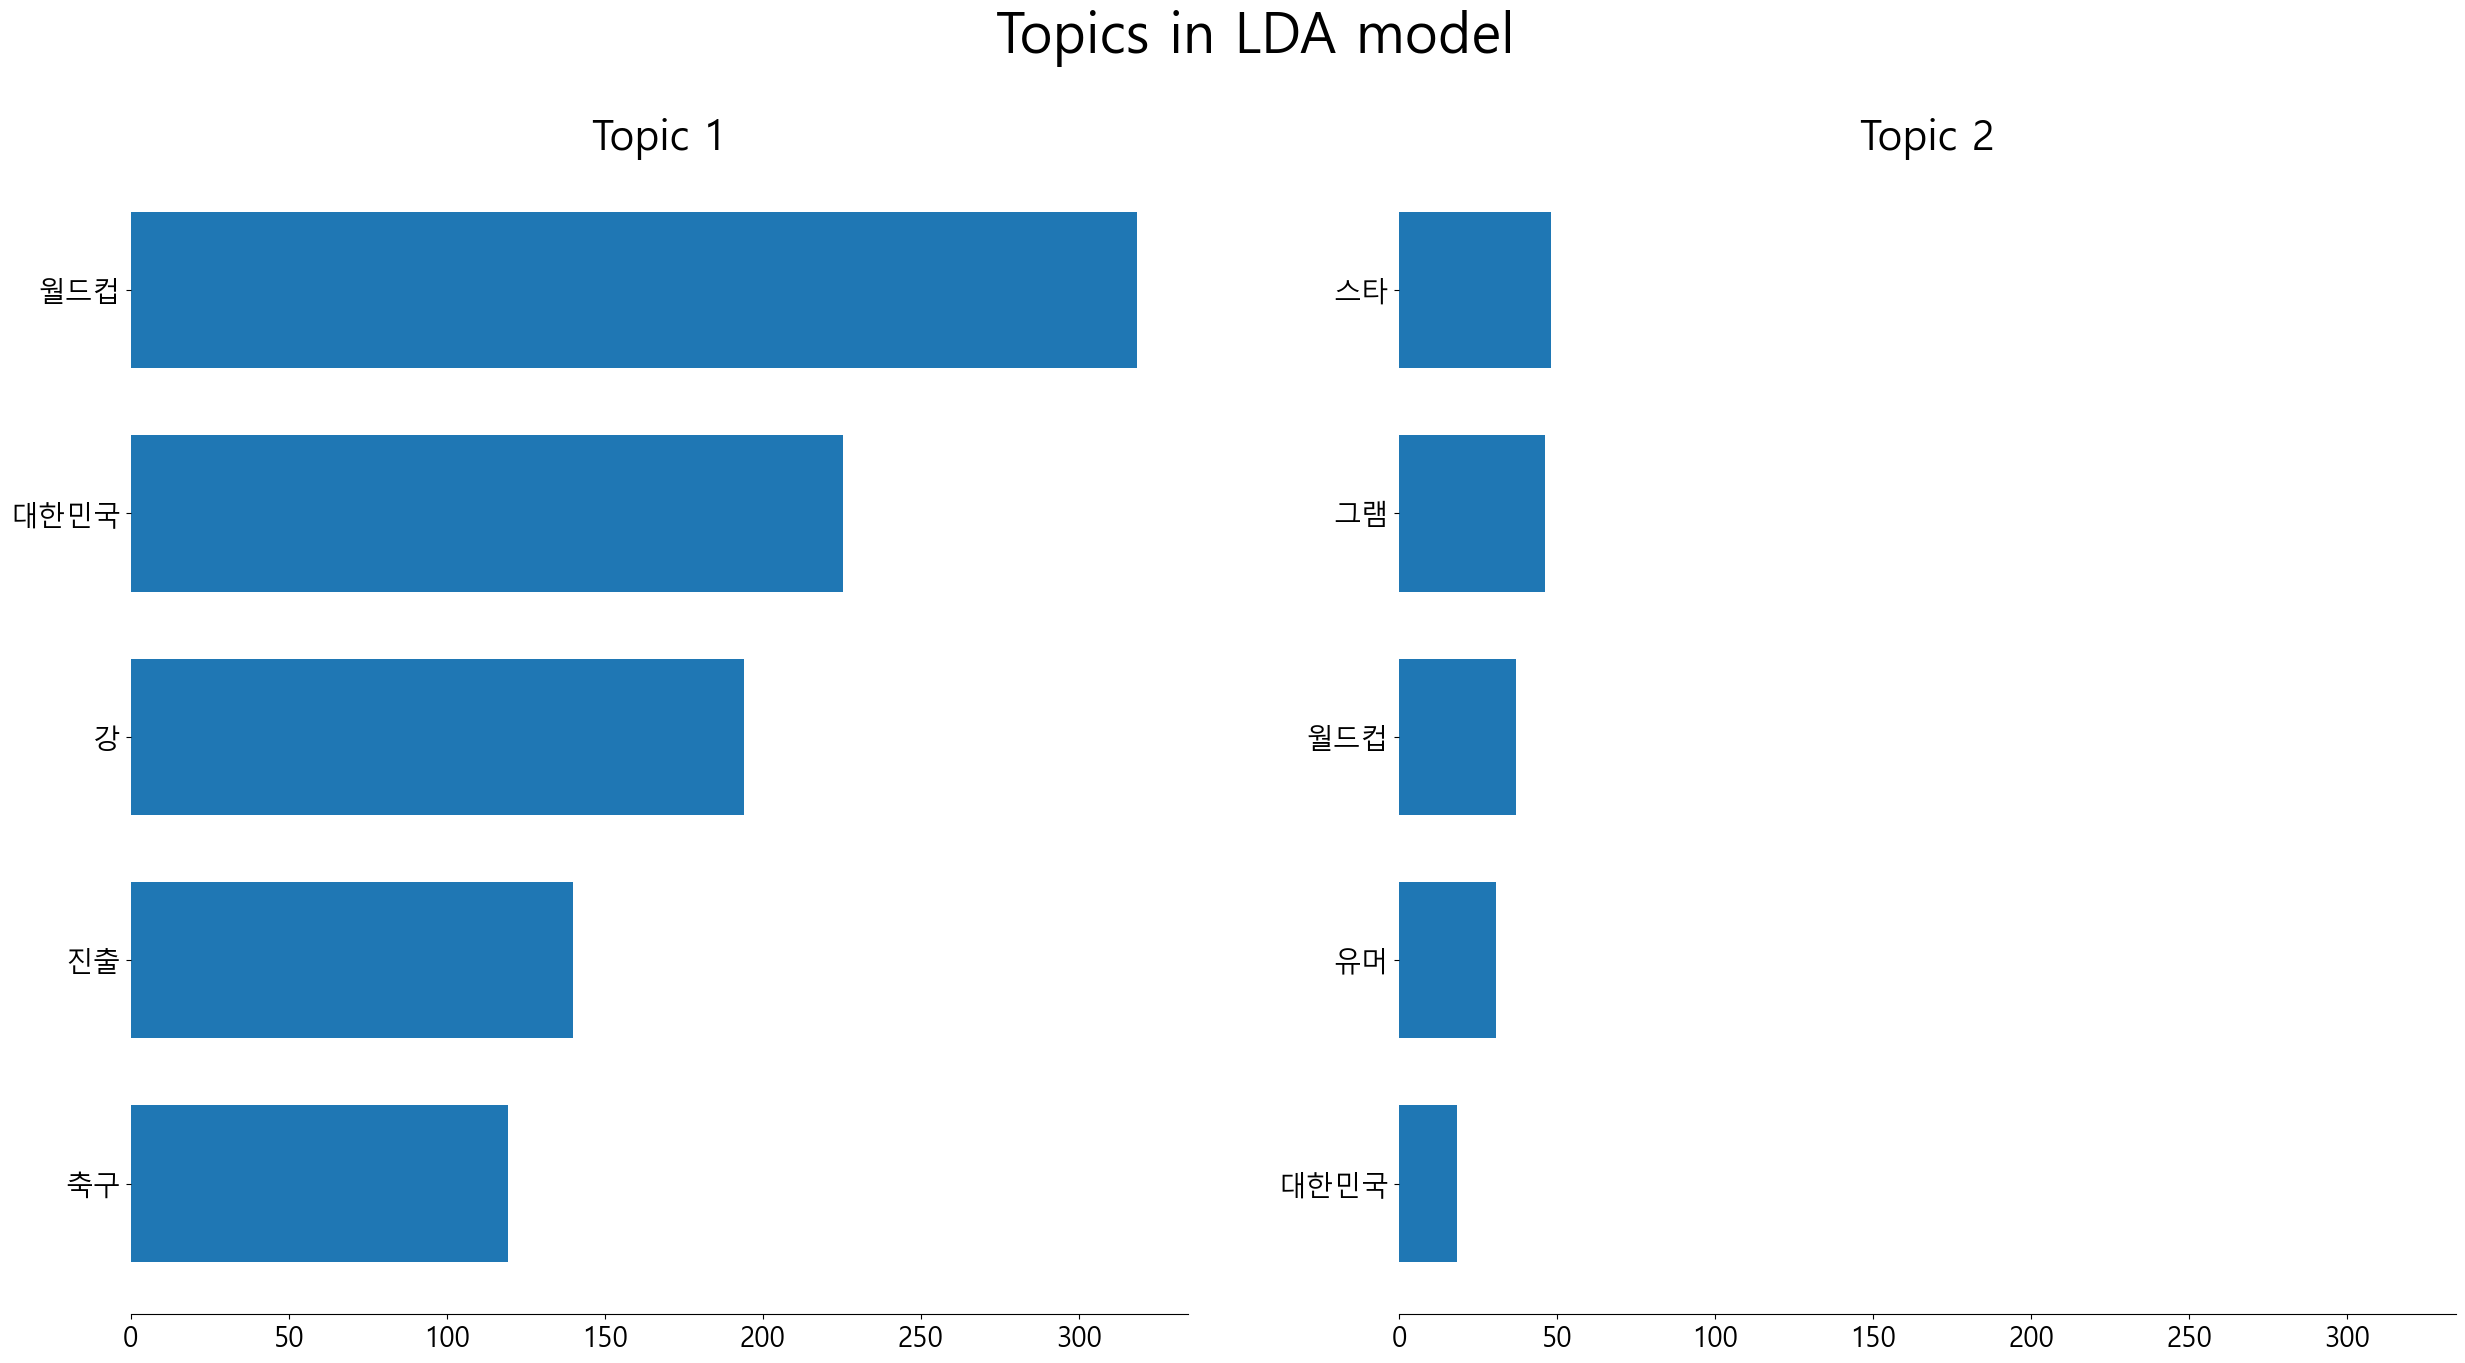

In [26]:
sklda(plaintext)